In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from tensorflow.keras.optimizers import AdamW
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


/tmp/ipykernel_3629468/228252157.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-30 18:24:58.317788: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 18:24:58.507406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 18:2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
train_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/train'
test_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/test'
val_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/val'

In [3]:
image_size=(224,224,3)
batch_size=32

In [4]:
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Load training and test images
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)
val_images, val_labels = load_images(val_dir)


# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
train_datagen.fit(train_images)


In [7]:
train_images.shape

(7459, 224, 224, 3)

In [8]:
print(train_labels)

[ 0  0  0 ... 24 24 24]


In [9]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=image_size)
for layer in base_model.layers[:-5]:  # Fine-tune top 5 layers
    layer.trainable = False



2024-04-30 18:31:45.514937: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-30 18:31:45.515111: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: AI-iiitg
2024-04-30 18:31:45.528211: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: AI-iiitg
2024-04-30 18:31:45.528551: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 545.23.8
2024-04-30 18:31:45.528619: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.23.8
2024-04-30 18:31:45.528630: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 545.23.8


In [10]:
# Add custom layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
predictions = Dense(25, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with AdamW optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Adjust patience as needed

In [12]:
# Train the model with data augmentation and early stopping
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=50,  # Adjust as needed
    validation_data=(val_images, val_labels),  # If using a validation set
    callbacks=[early_stopping]
)

Epoch 1/50
234/234 [==============================] - 337s 1s/step - loss: 10.0183 - accuracy: 0.7607 - val_loss: 8.6664 - val_accuracy: 0.7454
Epoch 2/50
234/234 [==============================] - 322s 1s/step - loss: 7.2397 - accuracy: 0.8966 - val_loss: 6.4173 - val_accuracy: 0.8765
Epoch 3/50
234/234 [==============================] - 337s 1s/step - loss: 5.4471 - accuracy: 0.9233 - val_loss: 4.7392 - val_accuracy: 0.9155
Epoch 4/50
234/234 [==============================] - 348s 1s/step - loss: 4.1050 - accuracy: 0.9318 - val_loss: 3.7550 - val_accuracy: 0.8787
Epoch 5/50
234/234 [==============================] - 302s 1s/step - loss: 3.0702 - accuracy: 0.9429 - val_loss: 2.7856 - val_accuracy: 0.9144
Epoch 6/50
234/234 [==============================] - 323s 1s/step - loss: 2.3091 - accuracy: 0.9440 - val_loss: 2.1481 - val_accuracy: 0.9003
Epoch 7/50
234/234 [==============================] - 311s 1s/step - loss: 1.7367 - accuracy: 0.9503 - val_loss: 1.6197 - val_accuracy: 0.916

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [14]:
# Train the model (adjust epochs and batch size as needed)
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/10
 13/234 [>.............................] - ETA: 3:20 - loss: 0.2263 - accuracy: 0.9519

234/234 [==============================] - 259s 1s/step - loss: 0.1596 - accuracy: 0.9690 - val_loss: 0.1088 - val_accuracy: 0.9881
Epoch 2/10
234/234 [==============================] - 253s 1s/step - loss: 0.1131 - accuracy: 0.9858 - val_loss: 0.0911 - val_accuracy: 0.9892
Epoch 3/10
234/234 [==============================] - 255s 1s/step - loss: 0.0941 - accuracy: 0.9882 - val_loss: 0.0887 - val_accuracy: 0.9859
Epoch 4/10
234/234 [==============================] - 255s 1s/step - loss: 0.0881 - accuracy: 0.9895 - val_loss: 0.0843 - val_accuracy: 0.9859
Epoch 5/10
234/234 [==============================] - 259s 1s/step - loss: 0.0892 - accuracy: 0.9902 - val_loss: 0.0836 - val_accuracy: 0.9859
Epoch 6/10
234/234 [==============================] - 257s 1s/step - loss: 0.0717 - accuracy: 0.9938 - val_loss: 0.0718 - val_accuracy: 0.9881
Epoch 7/10
234/234 [==============================] - 257s 1s/step - loss: 0.0604 - accuracy: 0.9952 - val_loss: 0.0632 - val_accuracy: 0.9892
Epoch 8/10

In [15]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [16]:
# Extract features using the model without the top layer in batches
# Get the penultimate layer's output
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)


batch_size=32
# Use the extract_features function to process images in batches
train_features = extract_features(feature_extractor, train_images, batch_size)
test_features = extract_features(feature_extractor, test_images, batch_size)

print("Shape of extracted train features:", train_features.shape)
print("Shape of extracted test features:", test_features.shape)

1/1 [==============================] - 1s 867ms/step


1/1 [==============================] - 1s 841ms/step
Shape of extracted train features: (7459, 1024)
Shape of extracted test features: (957, 1024)


In [17]:
test_features[0]

array([0.        , 0.55564433, 0.3546587 , ..., 0.54327524, 0.        ,
       0.41771305], dtype=float32)

In [18]:
# # Define the parameter grid
# param_grid = {'n_neighbors': [8], 'metric': ['minkowski']}
# Define the parameter grid for KNN
knn_param_grid = {'n_neighbors' : range(2,15),
               'metric' : ['minkowski','euclidean','manhattan']}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Use GridSearchCV to find the best parameters for KNN
grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_features, train_labels)

# Get the best parameters
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']


In [19]:
# Use the best parameters to train the final model
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric)
start_time = time.time()
final_knn_classifier.fit(train_features, train_labels)
train_time = time.time() - start_time

# Predict labels for the test set
knn_predictions = final_knn_classifier.predict(test_features)

# Evaluate accuracy
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print("Best KNN Parameters:", grid_search.best_params_)
print("Best KNN Accuracy:", knn_accuracy)

# Additional evaluation metrics
precision = precision_score(test_labels, knn_predictions, average='weighted')
recall = recall_score(test_labels, knn_predictions, average='weighted')
f1 = f1_score(test_labels, knn_predictions, average='weighted')


print("Train Time (sec):", train_time)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
print("Train Time (sec) Grid:", grid_train_time)

Best KNN Parameters: {'metric': 'minkowski', 'n_neighbors': 4}
Best KNN Accuracy: 0.9926854754440961
Train Time (sec): 0.014673709869384766
Train Time (sec) Grid: 0.07565665245056152


In [20]:
# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, knn_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Matthews Correlation Coefficient (MCC): 0.9914838893896497


In [21]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, knn_predictions)
precision = precision_score(test_labels, knn_predictions, average='weighted')

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# False omission rate
FOR_ = FN/(FN+TN)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [22]:
# Compute True Positive Rate (TPR), True Negative Rate (TNR), False Positive Rate (FPR)

# Display results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("True Positive Rate (TPR):", np.mean(TPR))
print("True Negative Rate (TNR):", np.mean(TNR))
print("False Positive Rate (FPR):", np.mean(FPR))
print("False Negative Rate (FNR):", np.mean(FNR))
print("False Discovery Rate (FDR):", np.mean(FDR))
print("False Omission Rate (FOR):", np.mean(FOR_))
print("Overall accuracy (ACC):",np.mean(ACC))


Precision: 0.9929619980219679
Recall: 0.9926854754440961
F1 Score: 0.9927069710600234
True Positive Rate (TPR): 0.981718487394958
True Negative Rate (TNR): 0.9997024407395594
False Positive Rate (FPR): 0.00029755926044060954
False Negative Rate (FNR): 0.018281512605042016
False Discovery Rate (FDR): 0.017392976588628765
False Omission Rate (FOR): 0.00029728686393224867
Overall accuracy (ACC): 0.9994148380355277


In [23]:
#Feature space (number of pixels in each image)
feature_space = train_images.shape
print("Feature Space:", feature_space)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)


Feature Space: (7459, 224, 224, 3)
Optimization Algorithm Accuracy: 0.9994637710085472


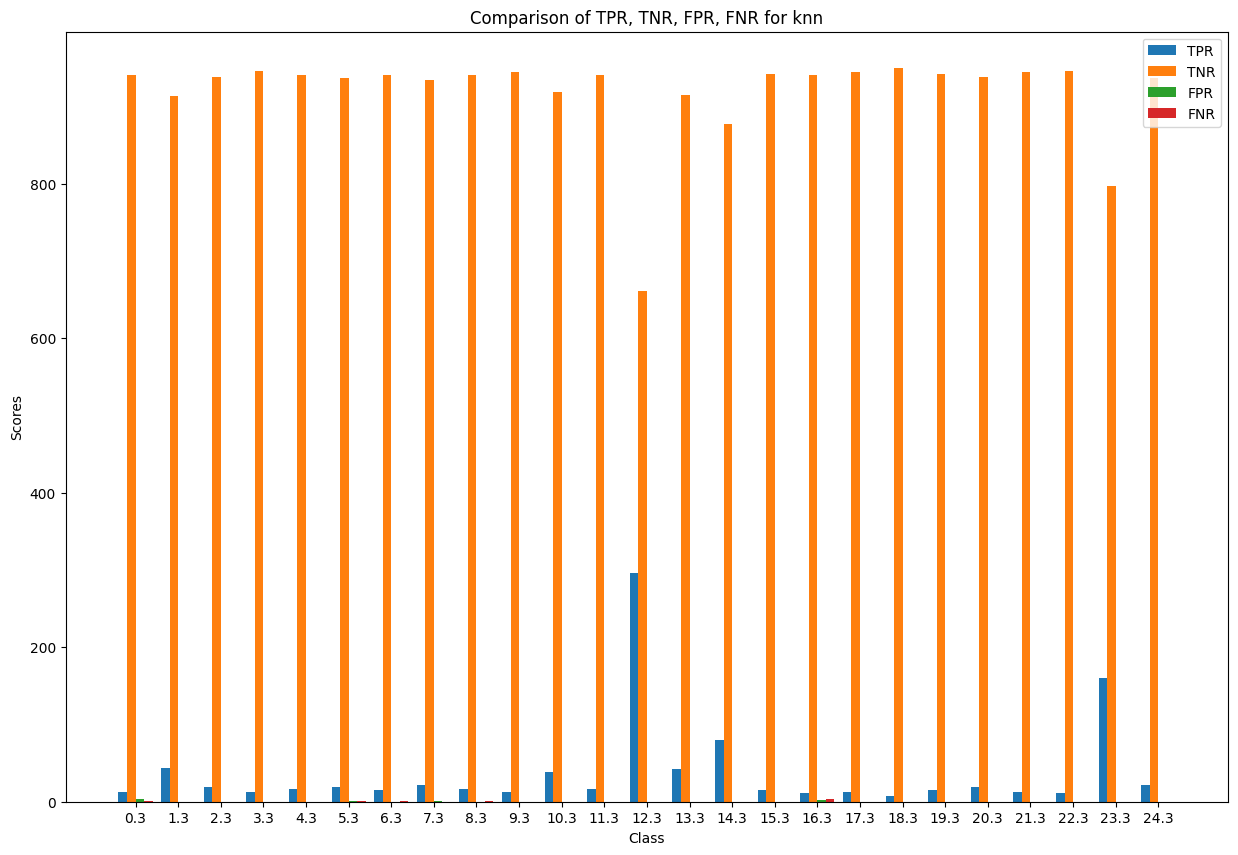

In [24]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

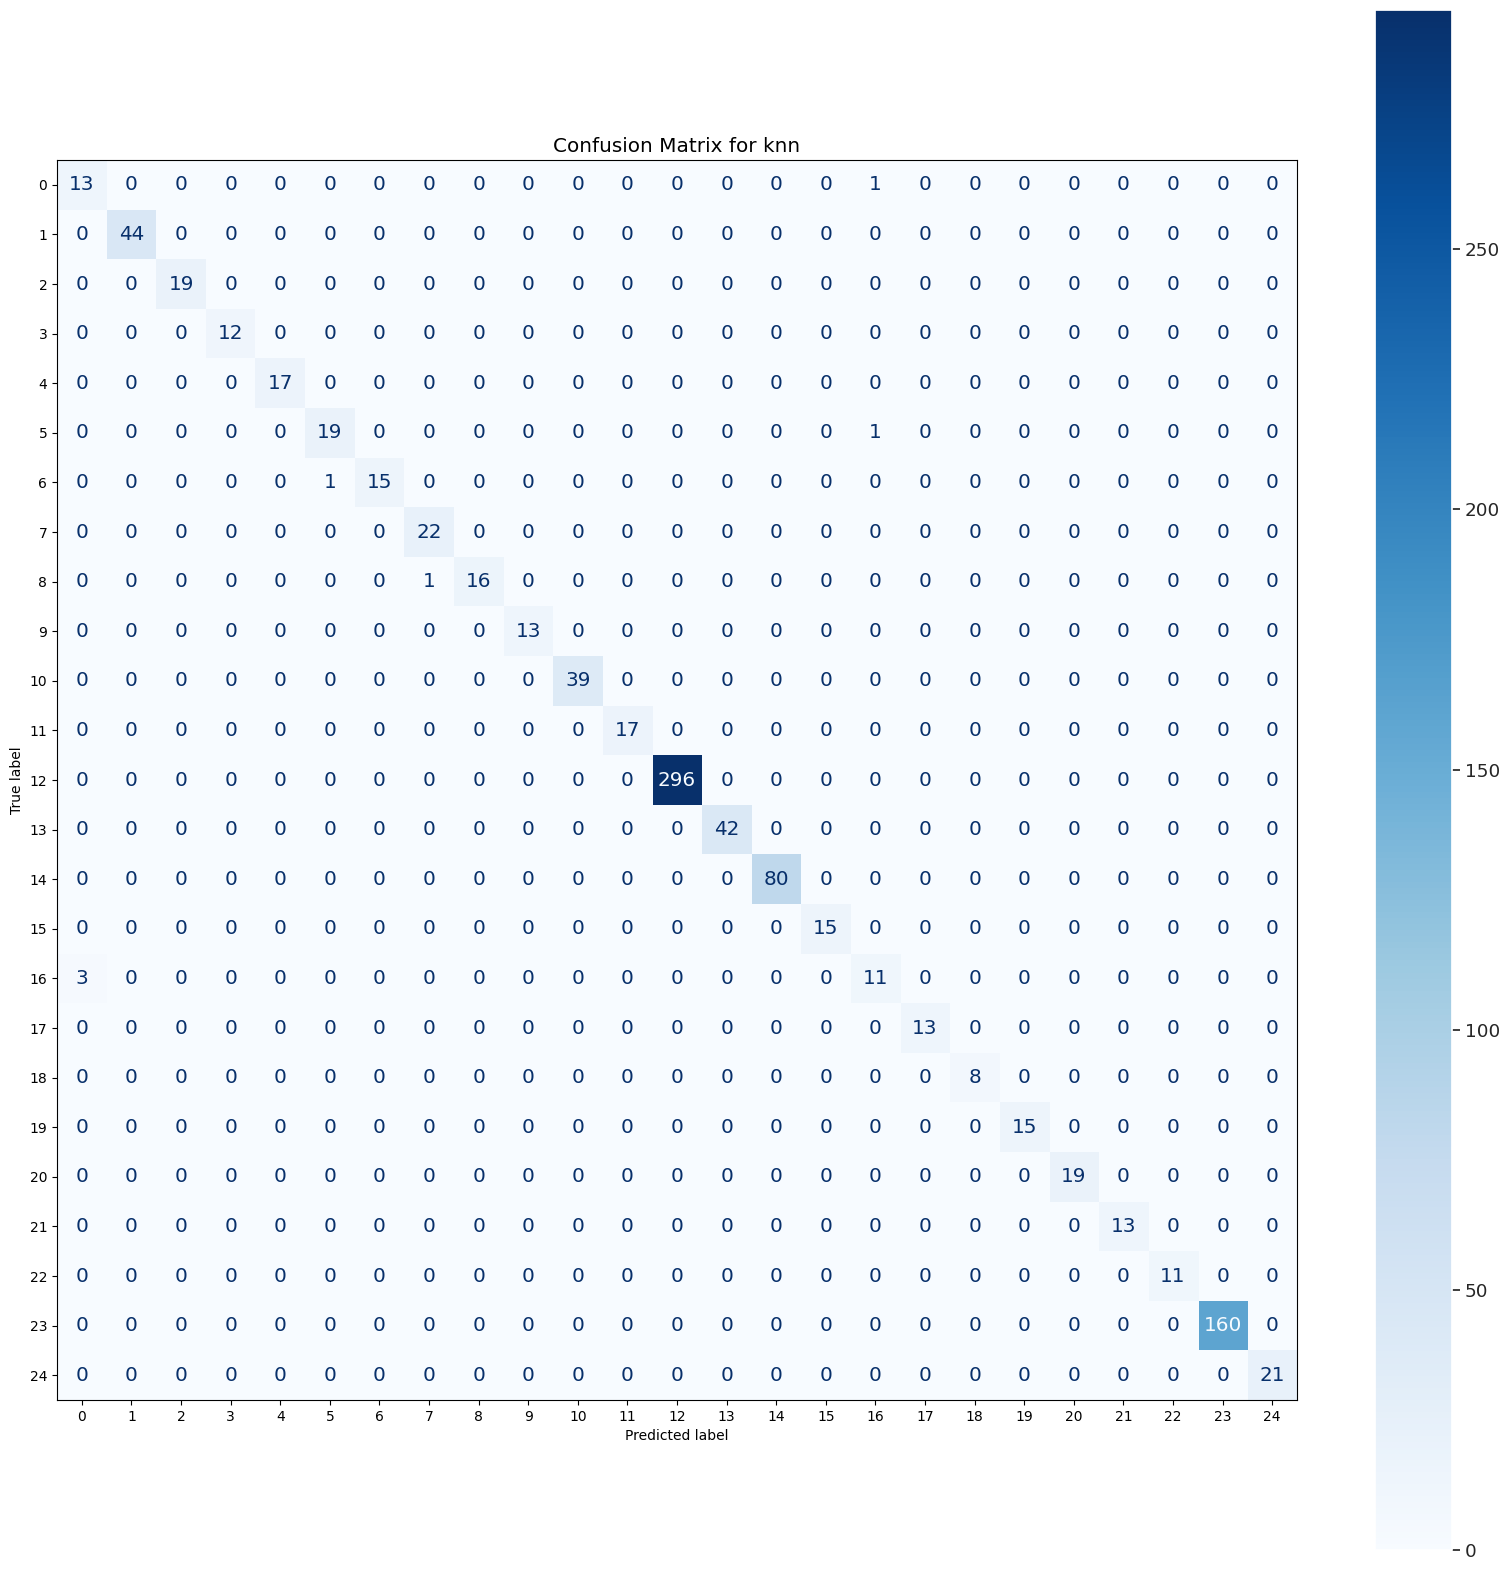

In [25]:
# Plot Confusion Matrix for Naive Bayes
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for knn')
plt.show()